## Sampling with diffusion models and compute the potential

This notebook shows how to draw new samples with Diffusion models and how to compute the potential (likelihood) of a sample 

In [ ]:
import torch
import deepinv as dinv 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

torch.manual_seed(0)
torch.cuda.manual_seed(0)

## EDM models: 

References: 
- https://github.com/NVlabs/edm 
- https://arxiv.org/abs/2206.00364
  


In [2]:
from edm.prior import ScorePrior, get_ode_flow, likelihood_fn, ode_sampler
from edm import load_model


Load a pre-trained score model 

In [3]:
model = load_model("edm-cifar10-32x32-uncond-ve.pkl").to(device)

def denoiser(x, t, *args, **kwargs):
    return model(x.to(torch.float32), t, *args, **kwargs).to(torch.float64)
prior = ScorePrior(denoiser=denoiser)

Sucessfully loaded the model edm-cifar10-32x32-uncond-ve.pkl
Number of parameters:  56397827


Generate a sample by ODE flow

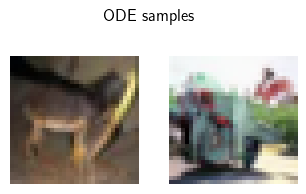

In [4]:

class_labels = torch.eye(1000, device=device)[torch.tensor([1,2], device=device)]
ode_flow, t_spans = get_ode_flow(prior)
ode_sample, nfe = ode_sampler(
    ode_flow, shape=(class_labels.size(0), 3, 32, 32), t_spans=t_spans, class_labels=class_labels, device=device
)
dinv.utils.plot([_ for _ in ode_sample], rescale_mode='min_max', suptitle='ODE samples')

Measure the potential of the generated images

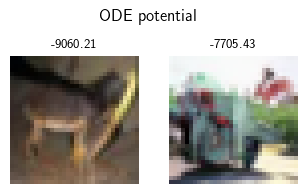

In [5]:
potential = likelihood_fn(ode_sample, ode_flow, t_spans=t_spans)
dinv.utils.plot([_ for _ in ode_sample], rescale_mode='min_max', suptitle='ODE potential', titles=[f"{p.item():.2f}" for p in potential])

## Song models

References: 
- https://arxiv.org/abs/2011.13456
- https://github.com/yang-song/score_sde_pytorch

In [ ]:
from songdiff.prior import get_likelihood_fn, get_score_model
from songdiff.sampling import get_sampling_fn 

In [7]:
score_model, sde, is_continuous, config = get_score_model('ncsnpp_ffhq256', device=device, dtype=dtype)
config.device = device
sampler_fn = get_sampling_fn(config, sde, shape=(1, 3, 256, 256), inverse_scaler=lambda x: (x + 1) / 2, eps=1e-3)
likelihood_fn = get_likelihood_fn(sde)

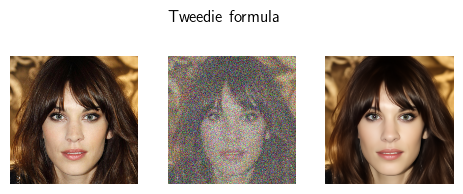

In [8]:
# Verify the score model by Tweedie formula
x = dinv.utils.load_url_image(
    dinv.utils.demo.get_image_url("celeba_example.jpg"),
    img_size=256,
    resize_mode="resize",
).to(device)

sigma = 0.2
xt = x + sigma * torch.randn_like(x)
with torch.no_grad():
    x0t = xt + sigma ** 2 * score_model(xt, torch.tensor([sigma], device=device))
dinv.utils.plot([x, xt, x0t], suptitle='Tweedie formula')

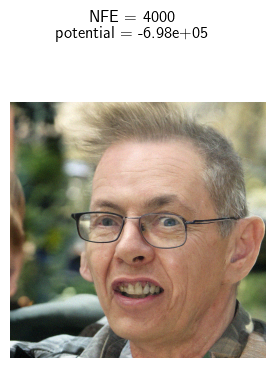

In [44]:
# Draw a sample
torch.manual_seed(111)
sample, nfe = sampler_fn(score_model)
potential = likelihood_fn(score_model, sample)

dinv.utils.plot(sample, rescale_mode='min_max', suptitle=f'NFE = {nfe} \n potential = {potential.item():.2e}', figsize=(4, 4))

## Blurry images are more likely

In [ ]:
from putils.convolution import GaussianBlur

kernel_fn = GaussianBlur(kernel_size=15, device=device)
physics = dinv.physics.BlurFFT(img_size=(3, 256, 256), device=device, dtype=dtype)

images = [sample]
potentials = [potential.item()]

for blur_level in torch.linspace(0.5, 3., 6):
    kernel = kernel_fn.kernel(blur_level)
    blurred = physics.A(sample, filter=kernel)
    potential = likelihood_fn(score_model, blurred)
    images.append(blurred)
    potentials.append(potential.item())

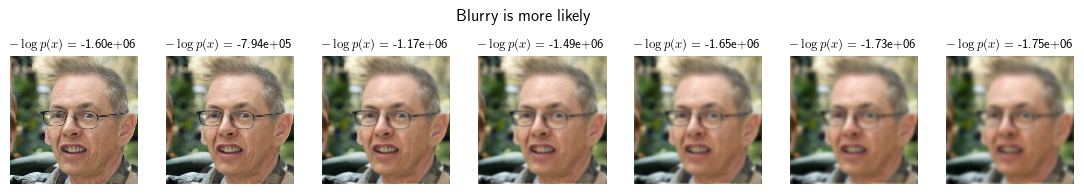

In [ ]:
dinv.utils.plot(images, suptitle='Blurry is more likely',
                titles=[rf"$-\log p(x) =$ {p:.2e}" for p in potentials],
                )